# Frequency correlation plots for simulated populations with nested clades

Example code for how to calculate frequency correlation plots from augur forecasting builds.

In [1]:
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [5]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["frequency_final"] > freq_df["frequency"])
        predicted_growth = (freq_df["projected_frequency"] > freq_df["frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["frequency_final"] <= freq_df["frequency"])
        predicted_decline = (freq_df["projected_frequency"] <= freq_df["frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [6]:
data_root = "../results/builds/simulated/simulated_sample_1/"

In [7]:
data_root_full_tree = "../results/builds/simulated/simulated_sample_1_full_tree/"

In [8]:
first_validation_timepoint = "2023-10-01"

In [9]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [10]:
tips = tips.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [11]:
tips.head(1)

,strain,timepoint,frequency
1155,sample_4616_1,2023-10-01,0.000012


In [12]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root_full_tree, sep="\t",
                             usecols=["tip", "clade_membership", "depth"])

In [13]:
tips_to_clades = tips_to_clades.rename(columns={"tip": "strain"})

In [14]:
tips_to_clades.head()

,strain,clade_membership,depth
0,sample_2188_1,f35b8e0,0
1,sample_2188_1,442749b,3
2,sample_2192_5,f35b8e0,0
3,sample_2192_5,442749b,3
4,sample_2224_7,f35b8e0,0


In [15]:
tips_to_clades.shape

(165375, 3)

In [16]:
forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "frequency", "projected_frequency"]
)

In [17]:
forecasts.head(1)

,timepoint,strain,frequency,projected_frequency
0,2016-10-01,sample_3216_5,0.000012,1.284285e-08


In [18]:
full_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [19]:
full_forecasts = full_forecasts.query("timepoint >= '%s'" % first_validation_timepoint).copy()

## Find large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [20]:
tips.head()

,strain,timepoint,frequency
1155,sample_4616_1,2023-10-01,0.000012
1156,sample_4616_5,2023-10-01,0.000012
1157,sample_4620_10,2023-10-01,0.000020
1158,sample_4620_8,2023-10-01,0.000020
1159,sample_4624_1,2023-10-01,0.000032


In [21]:
clade_tip_initial_frequencies = tips_to_clades.merge(
    tips,
    on=["strain"]
)

In [22]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency
0,sample_4624_1,6258722,0,2023-10-01,0.000032
1,sample_4624_1,d9d40fb,2,2023-10-01,0.000032
2,sample_4624_1,53689ce,3,2023-10-01,0.000032
3,sample_4624_1,2c08908,4,2023-10-01,0.000032
4,sample_4624_1,c392585,6,2023-10-01,0.000032


In [23]:
clade_tip_initial_frequencies["future_timepoint"] = clade_tip_initial_frequencies["timepoint"] + pd.DateOffset(months=12)

In [24]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,future_timepoint
0,sample_4624_1,6258722,0,2023-10-01,0.000032,2024-10-01
1,sample_4624_1,d9d40fb,2,2023-10-01,0.000032,2024-10-01
2,sample_4624_1,53689ce,3,2023-10-01,0.000032,2024-10-01
3,sample_4624_1,2c08908,4,2023-10-01,0.000032,2024-10-01
4,sample_4624_1,c392585,6,2023-10-01,0.000032,2024-10-01


In [25]:
initial_clade_frequencies = clade_tip_initial_frequencies.groupby([
    "timepoint", "future_timepoint", "clade_membership"
])["frequency"].sum().reset_index()

In [26]:
initial_clade_frequencies.head()

,timepoint,future_timepoint,clade_membership,frequency
0,2023-10-01,2024-10-01,0232a1e,0.999997
1,2023-10-01,2024-10-01,055939c,0.000020
2,2023-10-01,2024-10-01,0687bd9,0.130452
3,2023-10-01,2024-10-01,0873209,0.999997
4,2023-10-01,2024-10-01,0a07f85,0.029128


In [27]:
initial_clade_frequencies.query("clade_membership == 'cb64469'")

,timepoint,future_timepoint,clade_membership,frequency


Merge clade frequencies between adjacent years.

In [28]:
initial_and_observed_clade_frequencies = initial_clade_frequencies.merge(
    initial_clade_frequencies,
    left_on=["future_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_final"]
).groupby(["timepoint", "clade_membership", "frequency"])["frequency_final"].sum().reset_index()

In [29]:
initial_and_observed_clade_frequencies.query("clade_membership == 'cb64469'")

,timepoint,clade_membership,frequency,frequency_final


Select clades with an initial frequency >15%.

In [30]:
large_clades = initial_and_observed_clade_frequencies.query("frequency > 0.15").copy()

In [31]:
large_clades.head()

,timepoint,clade_membership,frequency,frequency_final
0,2023-10-01,0232a1e,0.999997,0.999992
2,2023-10-01,0873209,0.999997,0.999992
4,2023-10-01,0ecf707,0.794930,0.977510
5,2023-10-01,165aaed,0.999965,0.999992
6,2023-10-01,166c697,0.999997,0.999992


In [32]:
large_clades.tail()

,timepoint,clade_membership,frequency,frequency_final
2383,2039-10-01,e93d225,0.999995,0.999996
2384,2039-10-01,ece851e,0.999995,0.999996
2385,2039-10-01,f05d275,0.999995,0.999996
2386,2039-10-01,f660f57,0.999995,0.999996
2387,2039-10-01,f8351e7,0.228074,0.031659


In [33]:
large_clades.shape

(2082, 4)

In [34]:
large_clades["observed_growth_rate"] = (large_clades["frequency_final"] / large_clades["frequency"])

In [35]:
large_clades.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate
0,2023-10-01,0232a1e,0.999997,0.999992,0.999995
2,2023-10-01,0873209,0.999997,0.999992,0.999995
4,2023-10-01,0ecf707,0.794930,0.977510,1.229681
5,2023-10-01,165aaed,0.999965,0.999992,1.000027
6,2023-10-01,166c697,0.999997,0.999992,0.999995


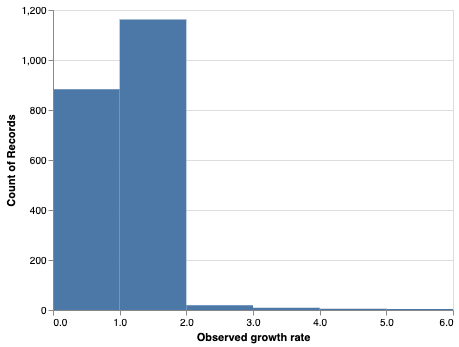

In [36]:
alt.Chart(large_clades).mark_rect().encode(
    x=alt.X("observed_growth_rate:Q", bin=True, title="Observed growth rate"),
    y="count()"
)

## Find estimated future frequencies of large clades

Use the true fitness metric for forecasts.

In [37]:
clade_tip_estimated_frequencies = tips_to_clades.merge(
    forecasts,
    on=["strain"]
)

In [38]:
clade_tip_estimated_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,projected_frequency
0,sample_3232_3,e51cd3b,0,2016-10-01,0.000074,8.254470e-07
1,sample_3232_3,43d15e1,4,2016-10-01,0.000074,8.254470e-07
2,sample_3232_3,6faf4e9,5,2016-10-01,0.000074,8.254470e-07
3,sample_3232_3,d6959c4,6,2016-10-01,0.000074,8.254470e-07
4,sample_3232_3,11285b2,8,2016-10-01,0.000074,8.254470e-07


In [39]:
estimated_clade_frequencies = clade_tip_estimated_frequencies.groupby(
    ["timepoint", "clade_membership"]
).aggregate({"projected_frequency": "sum"}).reset_index()

In [40]:
estimated_clade_frequencies.head()

,timepoint,clade_membership,projected_frequency
0,2016-10-01,0232a1e,1.000000e+00
1,2016-10-01,0873209,1.000000e+00
2,2016-10-01,11285b2,8.254470e-07
3,2016-10-01,122acf9,8.524955e-08
4,2016-10-01,12e78dd,3.666485e-01


In [41]:
complete_clade_frequencies = large_clades.merge(
    estimated_clade_frequencies,
    on=["timepoint", "clade_membership"],
    suffixes=["", "_other"]
)

In [42]:
complete_clade_frequencies["estimated_growth_rate"] = (
    complete_clade_frequencies["projected_frequency"] / complete_clade_frequencies["frequency"]
)

In [43]:
complete_clade_frequencies["year"] = complete_clade_frequencies["timepoint"].dt.year

In [44]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate,projected_frequency,estimated_growth_rate,year
0,2023-10-01,0232a1e,0.999997,0.999992,0.999995,1.000000,1.000003,2023
1,2023-10-01,0873209,0.999997,0.999992,0.999995,1.000000,1.000003,2023
2,2023-10-01,0ecf707,0.794930,0.977510,1.229681,0.782536,0.984409,2023
3,2023-10-01,165aaed,0.999965,0.999992,1.000027,1.000000,1.000035,2023
4,2023-10-01,166c697,0.999997,0.999992,0.999995,1.000000,1.000003,2023


In [45]:
complete_clade_frequencies.shape

(2082, 8)

In [46]:
r, p = pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

In [47]:
r

0.145324087213823

In [48]:
p

2.693951397044494e-11

In [49]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(complete_clade_frequencies, True)

In [50]:
mcc

0.2861444233023532

In [51]:
growth_accuracy = confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])
growth_accuracy

0.6271739130434782

In [52]:
decline_accuracy = confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])
decline_accuracy

0.8140495867768595

In [53]:
min_growth_rate = 0
max_growth_rate = complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

In [54]:
pseudofrequency = 0.001

In [55]:
complete_clade_frequencies["log_observed_growth_rate"] = (
    np.log10((complete_clade_frequencies["frequency_final"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

complete_clade_frequencies["log_estimated_growth_rate"] = (
    np.log10((complete_clade_frequencies["projected_frequency"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

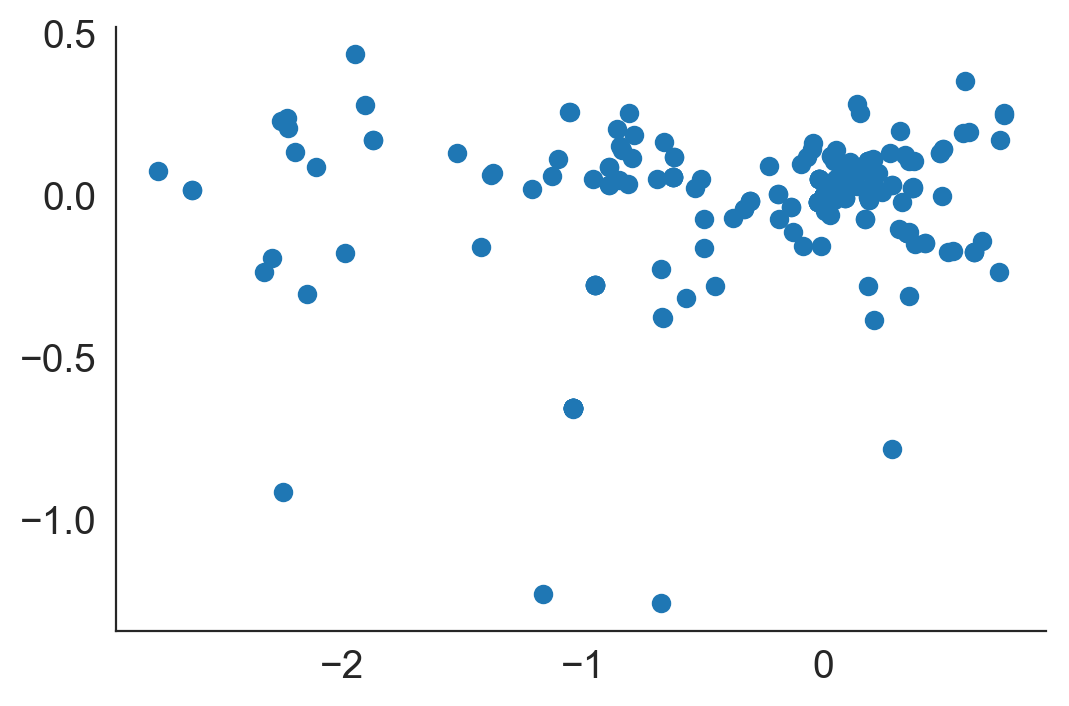

In [56]:
plt.plot(complete_clade_frequencies["log_observed_growth_rate"], complete_clade_frequencies["log_estimated_growth_rate"], "o")

In [57]:
#complete_clade_frequencies["log_observed_growth_rate"] = np.log(complete_clade_frequencies["observed_growth_rate"])
#complete_clade_frequencies["log_estimated_growth_rate"] = np.log(complete_clade_frequencies["estimated_growth_rate"])

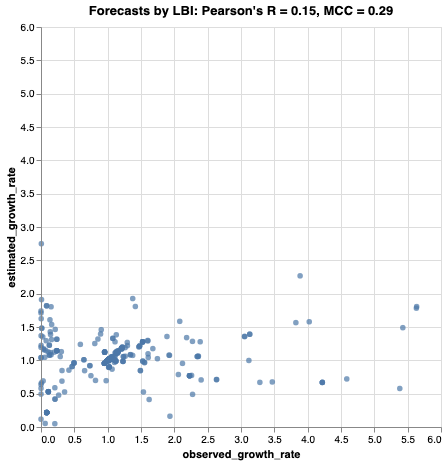

In [58]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("observed_growth_rate:Q", scale=alt.Scale(domain=(min_growth_rate, max_growth_rate))),
    alt.Y("estimated_growth_rate:Q", scale=alt.Scale(domain=(min_growth_rate, max_growth_rate))),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
)

#chart.save("forecast_growth_correlation_natural_lbi.svg")
chart

In [59]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate,projected_frequency,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate
0,2023-10-01,0232a1e,0.999997,0.999992,0.999995,1.000000,1.000003,2023,-0.000002,0.000001
1,2023-10-01,0873209,0.999997,0.999992,0.999995,1.000000,1.000003,2023,-0.000002,0.000001
2,2023-10-01,0ecf707,0.794930,0.977510,1.229681,0.782536,0.984409,2023,0.089690,-0.006816
3,2023-10-01,165aaed,0.999965,0.999992,1.000027,1.000000,1.000035,2023,0.000012,0.000015
4,2023-10-01,166c697,0.999997,0.999992,0.999995,1.000000,1.000003,2023,-0.000002,0.000001


In [60]:
upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max())

log_lower_limit = complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min() - 0.1
log_upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].max().max()) + 0.1

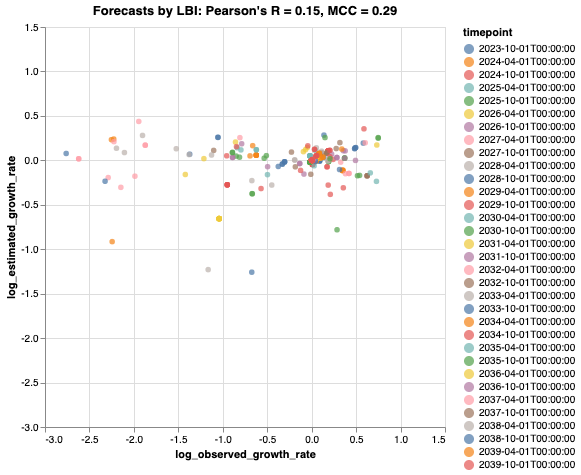

In [61]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("log_observed_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Y("log_estimated_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Color("timepoint:N"),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
).interactive()

#chart.save("forecast_log_growth_correlation_natural_lbi.svg")
chart

In [62]:
log_lower_limit

-2.8620029693751152

In [63]:
complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min()

-2.762002969375115

In [64]:
r, p = pearsonr(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"]
)

In [65]:
r

0.2052839305617188

In [66]:
p

3.01507607538443e-21

In [67]:
pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

(0.145324087213823, 2.693951397044494e-11)

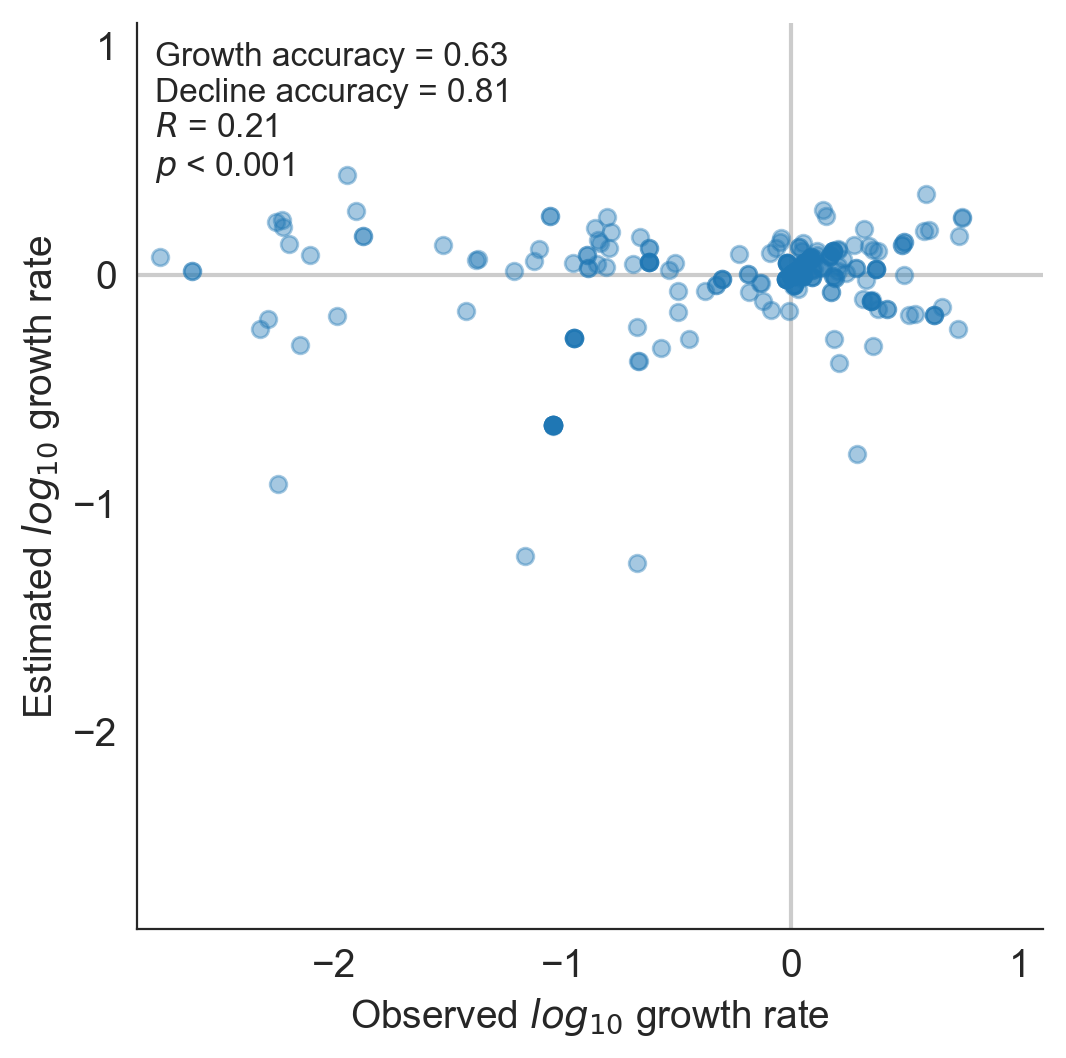

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

ax.axhline(color="#cccccc", zorder=-5)
ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes
)

ax.set_xlabel("Observed $log_{10}$ growth rate")
ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlim(log_lower_limit, log_upper_limit)
ax.set_ylim(log_lower_limit, log_upper_limit)
ax.set_aspect("equal")

#plt.savefig("../manuscript/figures/validation-of-best-model-for-natural-populations.pdf")

## Estimated and observed closest strains per timepoint

Create a figure similar to Figure 2D in Neher et al. 2014 showing the minimum estimated distance to the future and minimum observed distance to the future per timepoint.

In [69]:
sorted_df = full_forecasts.dropna().sort_values(
    ["timepoint"]
).copy()

In [70]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)

In [71]:
best_fitness_rank_by_timepoint_df = sorted_df.sort_values(
    ["timepoint", "fitness"],
    ascending=False
).groupby("timepoint")["timepoint_rank"].first().reset_index()

In [72]:
best_fitness_rank_by_timepoint_df.head()

,timepoint,timepoint_rank
0,2023-10-01,0.024390
1,2024-04-01,0.804878
2,2024-10-01,0.343373
3,2025-04-01,0.120482
4,2025-10-01,0.018072


Text(0,0.5,'Number of timepoints')

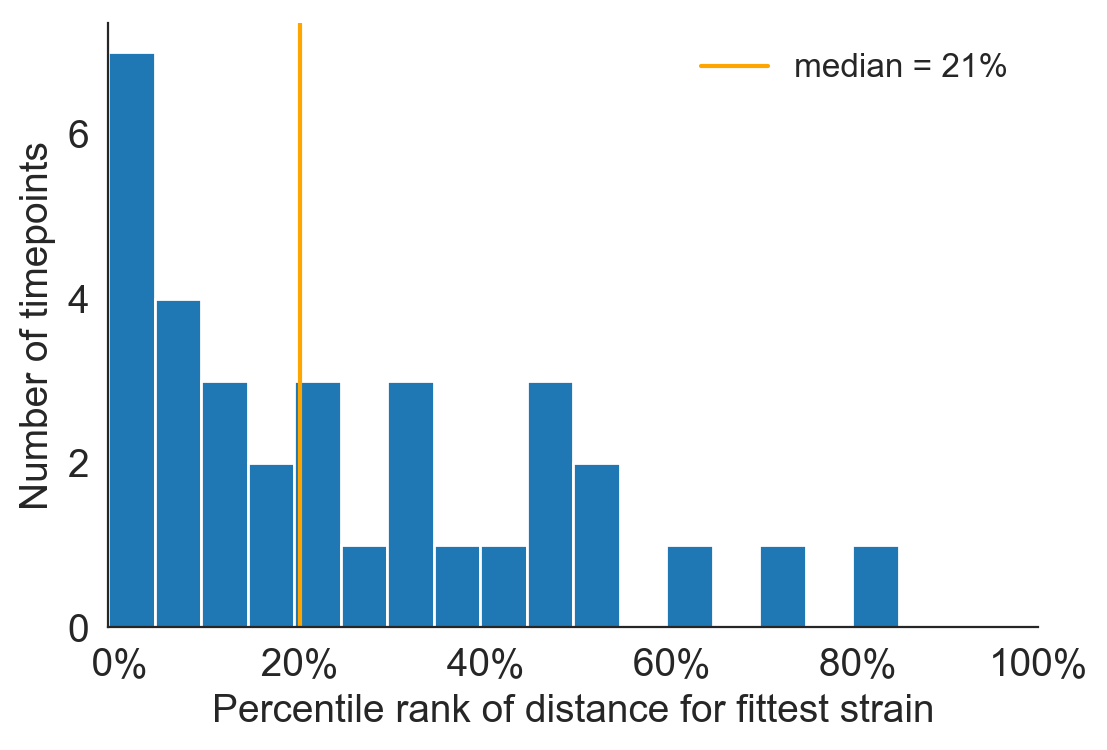

In [73]:
median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
ax.set_xlim(0, 1)

ax.legend(
    frameon=False
)
ax.set_xlabel("Percentile rank of distance for fittest strain")
ax.set_ylabel("Number of timepoints")

## Merge validation figures into subpanels of one figure

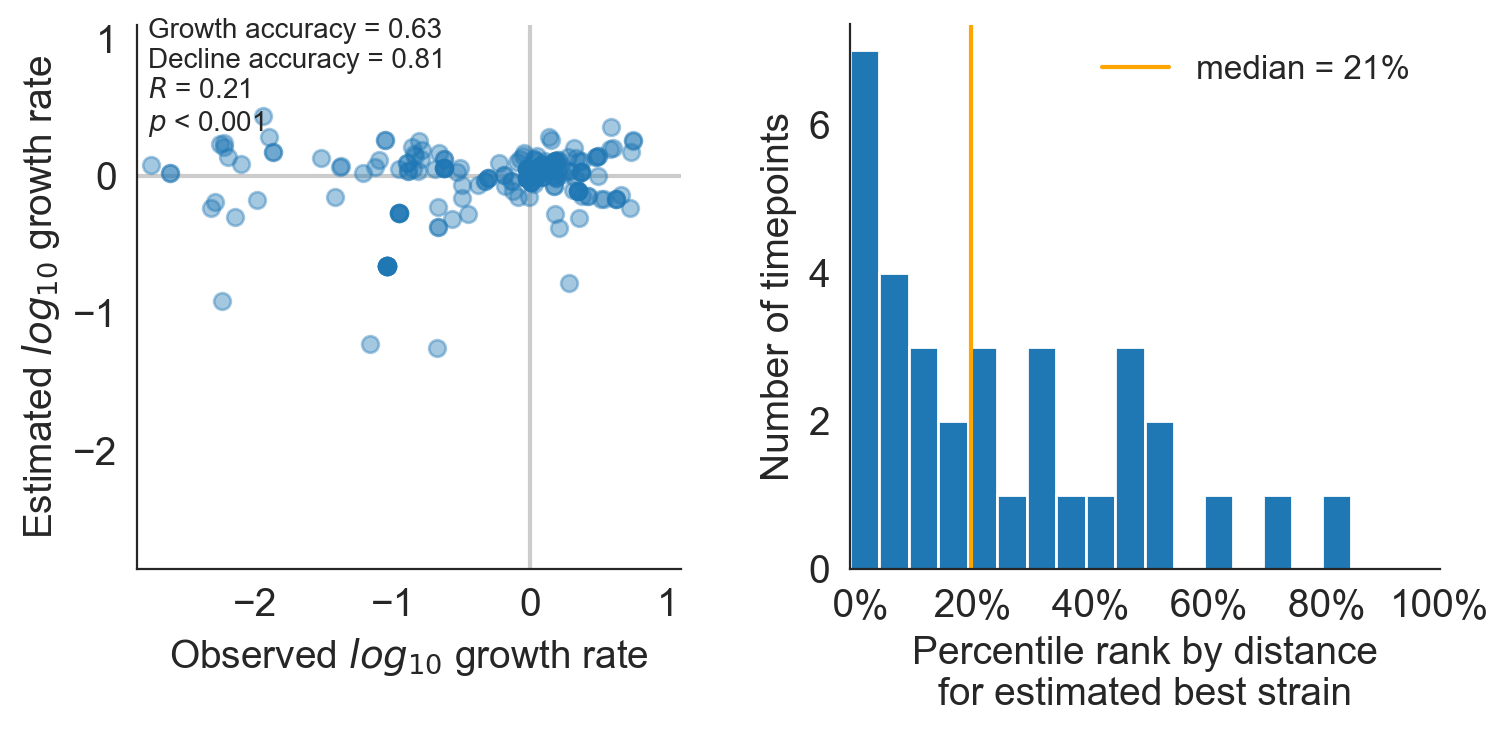

In [74]:
fig = plt.figure(figsize=(8, 4), facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

#
# Clade growth rate correlations
#

clade_ax = fig.add_subplot(gs[0])
clade_ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

clade_ax.axhline(color="#cccccc", zorder=-5)
clade_ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

clade_ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=10,
    horizontalalignment="left",
    verticalalignment="center",
    transform=clade_ax.transAxes
)

clade_ax.set_xlabel("Observed $log_{10}$ growth rate")
clade_ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
clade_ax.set_xticks(ticks)
clade_ax.set_yticks(ticks)

clade_ax.set_xlim(log_lower_limit, log_upper_limit)
clade_ax.set_ylim(log_lower_limit, log_upper_limit)
clade_ax.set_aspect("equal")

#
# Estimated closest strain to the future ranking
#

rank_ax = fig.add_subplot(gs[1])

median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

rank_ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
rank_ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
rank_ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
rank_ax.set_xlim(0, 1)

rank_ax.legend(
    frameon=False
)
rank_ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
rank_ax.set_ylabel("Number of timepoints")

gs.tight_layout(fig)

plt.savefig("../manuscript/figures/validation-of-best-model-for-simulated-populations.png")

In [75]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] < 0.2).sum()

16

In [76]:
best_fitness_rank_by_timepoint_df.shape

(33, 2)

In [77]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] < 0.2).sum() / float(best_fitness_rank_by_timepoint_df.shape[0])

0.48484848484848486